In [0]:
# This document/.ipynb file was originaly created by Sacha Dubrulle in Python 2 
# and further worked upon and converted to Python 3 by Thomas Valcke.
# This notebook has been converted to Python 3 because the syntax changed with Python 3.
# In this notebook a lot of files are required to make everything work but this file Runs 100% localy.
# When run on the server there was 1 Cell that did not work 
# ==> df.filter(df.text.contains("Viking Therapeutics")).collect()
# The reason for this cell not working is still unkown.

# <span style = 'color:darkred'> Set notebook to full width </span style>

In [0]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# <span style = 'color:darkred'> Notebook structure </span style>

- ### <a href=#imports> Imports  </a>
- ### <a href=#read_in> Reading in (sub)set </a>
- ### <a href=#tickers_ipo_extraction> Extracting ticker formatted strings and tweets containing IPO </a>
- ### <a href=#redun_columns> Drop standard redundant columns after checking</a>
- ### <a href=#expand_subcols> Expand the subcolumns that do not contain WrapperArrays </a>
- ### <a href=#check_and_drop_redundant_cols> Check for non-standard redundant columns and drop them </a>
- ### <a href=#none> ... </a>



# <span style = 'color:darkred'> Imports </span style>

In [0]:
import pandas as pd
import os
import sys
import csv
os.environ['SPARK_HOME'] = 'D:/School/STAGE_BP/spark' # your spark enviremnt 
import pyspark

from pyspark.sql import SQLContext, SparkSession

try:
    sc = pyspark.SparkContext(appName = 'App')
    spark = SparkSession(sparkContext=sc)
    print("SparkSession initialized")
except ValueError:
    print("SparkSession already initialized")

SparkSession initialized


# <span style = 'color:darkred'> To do </span style>

- Add remaining 7000 tweets that are not yet included for 2016
- Based on tweets with a known ticker -> find tweets based on language analysis that talk about IPO without necessarilty containing a tickerm

# <span style = 'color:darkred'> Imports </span style> <a name='imports' />

In [0]:
# Python imports
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import glob

# Spark imports
from pyspark.sql.functions import udf, year, month, dayofmonth, explode, lower, regexp_extract, split, upper
from pyspark.sql.types import *
import time
from datetime import datetime

# <span style = 'color:darkred'> ETL </span style> <a name='read_in' />

## <span style = 'color:green'> Reading in tweets </span style> <a name='read_in' />

In [0]:
from IPython.display import display  
from ipywidgets import FloatProgress  
import time

# Files containg path
path = "D:/School/STAGE_BP/testSCP/tweetsold/*.json"

df = (spark.read.json(path))

original_columns = df.columns

df = (df.withColumnRenamed("id_str", "tweet_id_str") #rename to avoid confusion with user_id, retweet_id, ...
        .withColumn("user_id_str", df.user.id_str) 
        .select("tweet_id_str","created_at",  "text", "user_id_str", "entities", "lang", "in_reply_to_status_id_str", "in_reply_to_user_id_str", "is_quote_status")
     )

print("The original columns were: {}".format(original_columns))


The original columns were: ['contributors', 'coordinates', 'created_at', 'entities', 'extended_entities', 'favorite_count', 'favorited', 'filter_level', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place', 'possibly_sensitive', 'quoted_status', 'quoted_status_id', 'quoted_status_id_str', 'retweet_count', 'retweeted', 'retweeted_status', 'scopes', 'source', 'text', 'timestamp_ms', 'truncated', 'user', 'withheld_in_countries']


In [0]:
#df.show()

+------------------+--------------------+--------------------+------------------+--------------------+----+-------------------------+-----------------------+---------------+
|      tweet_id_str|          created_at|                text|       user_id_str|            entities|lang|in_reply_to_status_id_str|in_reply_to_user_id_str|is_quote_status|
+------------------+--------------------+--------------------+------------------+--------------------+----+-------------------------+-----------------------+---------------+
|721800321610027008|Sun Apr 17 20:39:...|RT @ConnorFranta:...|        4882352700|[[], [[pic.twitte...|  en|                     null|                   null|          false|
|721800321719263232|Sun Apr 17 20:39:...|RT @NFL: The LOB ...|        2179414082|[[], [[pic.twitte...|  en|                     null|                   null|          false|
|721800321610088448|Sun Apr 17 20:39:...|Brunch y todo per...|          24324332|   [[],, [], [], []]|  es|                     nu

In [0]:
#df.select("entities").show(10, truncate = False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|entities                                                                                                                                                                                                                                                                                                                                                                                                        

In [0]:
#df.printSchema()
#df.select("retweeted_status").rdd.take(1)

## <span style = 'color:darkgreen'> Extracting tickers & presence of IPO out of text </span style> <a name='tickers_ipo_extraction' />

 - containing $-sign in the text or containing ipo

In [0]:
# REGEX to extract tickers or presence of IPO
ticker_expression_no_numbers = '(\s\$[A-Za-z]{1,6})+'
ticker_expression_including_numbers = '\$[A-Za-z0-9]{1,6}'
ipo_expression = '#ipo|ipo|#IPO|IPO'

df_tickers = (df.withColumn("tickers", regexp_extract('text', ticker_expression_no_numbers, 0))
                .withColumn("contains_ipo", regexp_extract('text', ipo_expression, 0))
            )

In [0]:
# Filter full dataset for tweets that contain either a ticker-pattern or the IPO pattern
df_tickers_and_ipo = df_tickers.filter((df_tickers["tickers"] != "") | (df_tickers["contains_ipo"] != ""))

print("There are {} tweets in the total set that containt the word ipo or a pattern that matches a ticker, including the dollar sign".format(df_tickers.count()))

#df_tickers_and_ipo.select("tweet_id_str", "contains_ipo", "tickers").show(5)
#df.createOrReplaceTempView("dfSQL")

There are 59100 tweets in the total set that containt the word ipo or a pattern that matches a ticker, including the dollar sign


In [0]:
# Filter out the tweets that contain one or multiple tickers
df_tickers = (df_tickers_and_ipo.filter(df_tickers["tickers"] != ""))

""
df_tickers = (df_tickers.select("tweet_id_str", "user_id_str", "text", "created_at","lang", split(df_tickers.tickers, '\s\$').alias('tickers')))

df_tickers = df_tickers.withColumn("ticker", explode(df_tickers.tickers)).select("tweet_id_str", "user_id_str","text", "ticker", "created_at", "lang")
df_tickers = df_tickers.filter(df_tickers.ticker != "")

aggregated_tickers = (df_tickers.withColumn("ticker", upper(df_tickers.ticker))
                                .groupBy("ticker").count()
                                .withColumnRenamed('count', "ticker_occurence")
                     )
aggregated_tickers = aggregated_tickers.sort(aggregated_tickers.ticker_occurence.desc())

#aggregated_tickers.coalesce(1).write.csv("ticker_occurence_2016", mode = "overwrite")


In [0]:
#aggregated_tickers.rdd.take(10)

[Row(ticker='IPO', ticker_occurence=3),
 Row(ticker='UHLN', ticker_occurence=3),
 Row(ticker='SELB', ticker_occurence=2),
 Row(ticker='CRVS', ticker_occurence=2),
 Row(ticker='ONOV', ticker_occurence=2),
 Row(ticker='SNSS', ticker_occurence=1),
 Row(ticker='ESES', ticker_occurence=1),
 Row(ticker='ARA', ticker_occurence=1),
 Row(ticker='HPP', ticker_occurence=1),
 Row(ticker='FSM', ticker_occurence=1)]

In [0]:
# Assigning the text with respect to teh ticker

for t in ("ARA", "VKTX", "RRR", "RETA", "HTGM", "OMF", "BOLD", "ESES", "SBPH"):
    one_ticker_df = df_tickers.filter(df_tickers.ticker == t)
    print("Ticker: {}".format(t))
    print(one_ticker_df.count())
    one_ticker_df.show(10)
    #one_ticker_df.write.json("{}_tweets.json".format(t), mode = "overwrite")
    
    

Ticker: ARA
1
+------------------+------------------+--------------------+------+--------------------+----+
|      tweet_id_str|       user_id_str|                text|ticker|          created_at|lang|
+------------------+------------------+--------------------+------+--------------------+----+
|722477177468547075|722183184155160576|Which #IPO will b...|   ARA|Tue Apr 19 17:29:...|  en|
+------------------+------------------+--------------------+------+--------------------+----+

Ticker: VKTX
0
+------------+-----------+----+------+----------+----+
|tweet_id_str|user_id_str|text|ticker|created_at|lang|
+------------+-----------+----+------+----------+----+
+------------+-----------+----+------+----------+----+

Ticker: RRR
0
+------------+-----------+----+------+----------+----+
|tweet_id_str|user_id_str|text|ticker|created_at|lang|
+------------+-----------+----+------+----------+----+
+------------+-----------+----+------+----------+----+

Ticker: RETA
0
+------------+-----------+---

In [0]:
#df.filter("Viking Therapeutics" in df.text)
df.filter(df.text.contains("Viking Therapeutics")).collect()

[]

In [0]:
# obsorved semicolons in the text, replaced with comma
replaceSemicolon = udf(lambda x: x.replace(";", ","))
edit_df = df.withColumn("text", replaceSemicolon(df.text))

In [0]:
#edit_df = edit_df.withColumn("text", replaceSemicolon(edit_df.text))

In [0]:
#edit_df.rdd.take(1)

[Row(tweet_id_str='721800321610027008', created_at='Sun Apr 17 20:39:41 +0000 2016', text='RT @ConnorFranta: when im bored i like to edit old photos ive taken but never posted.. heres a few https://t.co/rAT4Sehx6T', user_id_str='4882352700', entities=Row(hashtags=[], media=[Row(display_url='pic.twitter.com/rAT4Sehx6T', expanded_url='http://twitter.com/ConnorFranta/status/721787057903800320/photo/1', id=721787039947984896, id_str='721787039947984896', indices=[99, 122], media_url='http://pbs.twimg.com/media/CgRNfReUkAAy30a.jpg', media_url_https='https://pbs.twimg.com/media/CgRNfReUkAAy30a.jpg', sizes=Row(large=Row(h=1314, resize='fit', w=1024), medium=Row(h=770, resize='fit', w=600), small=Row(h=436, resize='fit', w=340), thumb=Row(h=150, resize='crop', w=150)), source_status_id=721787057903800320, source_status_id_str='721787057903800320', source_user_id=180949358, source_user_id_str='180949358', type='photo', url='https://t.co/rAT4Sehx6T')], symbols=[], urls=[], user_mentions=[Row(id=

In [0]:
#edit_df.write.csv("editas_tweets.csv", mode = "overwrite", sep = ";")
edit_df.write.csv("D:/School/STAGE_BP/ipo/editas_tweets.csv").mode('overwrite').delimiter(";")

In [0]:
#counting the amount of tweets
edit_df.count()


59100

In [0]:
#counting for number of tweets tweeed by userID
users_df = (df_tickers.select("user_id_str")
                   .groupBy("user_id_str")
                   .count()
                   .withColumnRenamed("count", "nbr_tweets_with_ticker")
        )

In [0]:

stockbard_id = "738550990698336261"

In [0]:
#sorting in descending order
users_df = (users_df.sort(users_df.nbr_tweets_with_ticker.desc())
            )

users_df.filter(users_df.user_id_str != stockbard_id)

users_df.count()

users_df.show(10)

+------------------+----------------------+
|       user_id_str|nbr_tweets_with_ticker|
+------------------+----------------------+
|        2752854968|                    15|
|          38197397|                     7|
|        3316797476|                     4|
|        3111496845|                     3|
|          79247391|                     3|
|722183184155160576|                     3|
|        2997788563|                     2|
|        1911185905|                     2|
|         164252605|                     2|
|721841449831108613|                     2|
+------------------+----------------------+
only showing top 10 rows



# <span style = 'color:darkred'> Language </span style>

In [0]:
#counting tweets by language
df_lang = (df_tickers.select("lang")
                .groupBy("lang")
                .count()
                .withColumnRenamed("count", "languageCount")
                .orderBy("count", ascending = False)
    )


df_lang.show(10)


+----+-------------+
|lang|languageCount|
+----+-------------+
|  en|           56|
| und|            4|
|  cs|            2|
|  de|            1|
|  in|            1|
|  hi|            1|
|  nl|            1|
|  es|            1|
+----+-------------+



# <span style = 'color:darkred'> Distribution of tweets over time </span style>

In [0]:
# UDF to convert created_at (String) to created_at_datetime (TimestampType)

def created_at_string_to_timestamp(x):
    return datetime.strptime(x,'%a %b %d %H:%M:%S +0000 %Y')

to_datetimestamp =  udf (created_at_string_to_timestamp, TimestampType())

In [0]:
df = df_tickers
df

DataFrame[tweet_id_str: string, user_id_str: string, text: string, ticker: string, created_at: string, lang: string]

In [0]:
get_ipython().run_cell_magic('time', '', '\ndf = df.withColumn(\'created_at_timestamp\', to_datetimestamp(df.created_at))\n\ndf_time = (df.select(year("created_at_timestamp").alias("year"),\n                 month("created_at_timestamp").alias("month"),\n                 dayofmonth("created_at_timestamp").alias("dayofmonth")\n                 )\n            .groupBy("dayofmonth", "month", "year")\n            .count()\n            .withColumnRenamed("count", "tweets_per_day")\n            .orderBy("year", "month", "dayofmonth", ascending = True)\n)\n\ndf_time_pandas = df_time.toPandas()\ndf_time_pandas[\'date\'] = df_time_pandas.apply(lambda x: datetime.strptime(\'%s/%s/%s\' % (x.dayofmonth, x.month, x.year), \'%d/%m/%Y\'),axis=1)\n\n#df_time_pandas')


Wall time: 5.87 s


In [0]:
# Creating new variable number of thousand tweets per day from tweets per day
df_time_pandas["tweets_per_day_thousands"] = df_time_pandas["tweets_per_day"].apply(lambda x: x/float(1000))

def labels(x):
    if x.day == 1:
        return str(x)[0:10]
    else:
        return " "

df_time_pandas["label_x_axis"] = df_time_pandas["date"].apply(lambda x: labels(x))
df_time_pandas


,dayofmonth,month,year,tweets_per_day,date,tweets_per_day_thousands,label_x_axis
0,1,4,2016,2,2016-04-01,0.002,2016-04-01
1,6,4,2016,1,2016-04-06,0.001,
2,7,4,2016,1,2016-04-07,0.001,
3,8,4,2016,1,2016-04-08,0.001,
4,9,4,2016,2,2016-04-09,0.002,
5,11,4,2016,4,2016-04-11,0.004,
6,13,4,2016,1,2016-04-13,0.001,
7,14,4,2016,3,2016-04-14,0.003,
8,19,4,2016,3,2016-04-19,0.003,
9,21,4,2016,1,2016-04-21,0.001,


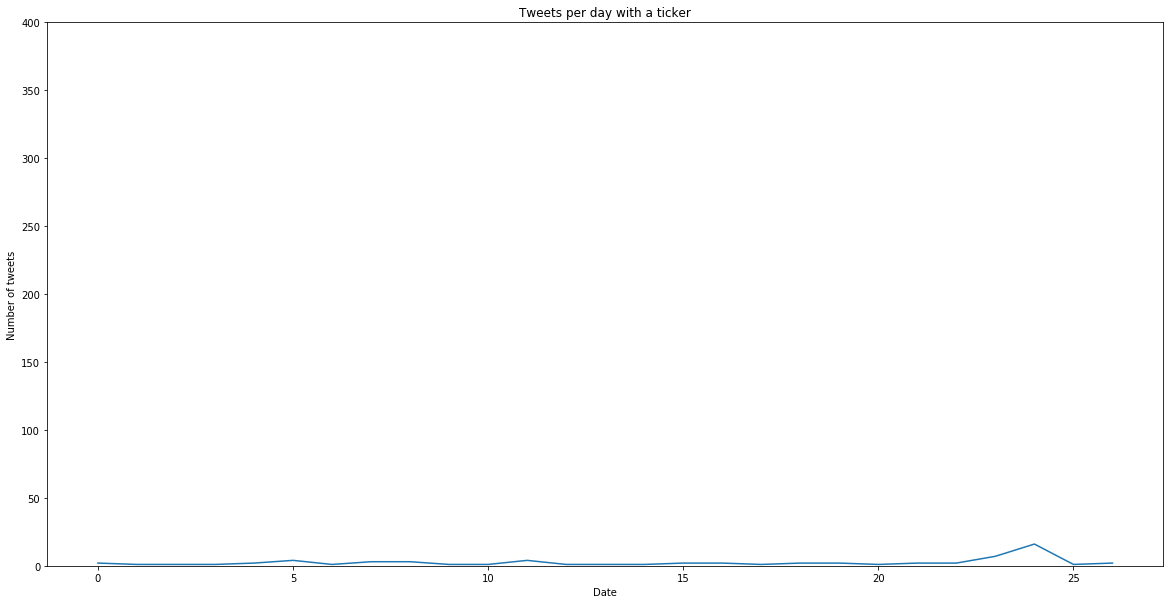

In [0]:
#plot tweets per day with ticker 
fig,ax = plt.subplots(figsize=(20,10))
plt.plot(df_time_pandas.tweets_per_day)

plt.xlabel("Date")
plt.ylabel("Number of tweets")

plt.ylim(ymin = 0, ymax = 400)

plt.title("Tweets per day with a ticker")

plt.show()

# <span style = 'color:darkred'> Hashtags </span style>

In [0]:
#df_hashtags = (df.select('tweet_id_str', "entities")
#                 .withColumnRenamed("text", "hashtag_array")
#              )

#df_hashtags = df_hashtags.select("tweet_id_str", explode(df_hashtags.hashtag_array).alias("hashtags"))

#df_hashtags = df_hashtags.select("tweet_id_str", lower(df_hashtags['hashtags']).alias("hashtags"))


In [0]:
#df.show()

In [0]:

#df_hashtags.createOrReplaceTempView("hashtagsSQL")
 
#df_top = spark.sql("SELECT hashtags, count(hashtags) as count FROM hashtagsSQL GROUP BY hashtags ORDER BY 2 DESC ").show()


In [0]:
#df.count()

67

In [0]:
df_time_pandas.count()

dayofmonth                  27
month                       27
year                        27
tweets_per_day              27
date                        27
tweets_per_day_thousands    27
label_x_axis                27
dtype: int64